In [1]:
# import nibabel as nib
# from nipype.interfaces import fsl
# from scipy.optimize import curve_fit
# from scipy import stats
# import numpy as np
# import pandas as pd
# import os
# from shutil import copyfile
# import matplotlib.pyplot as plt
# from collections import OrderedDict

from nipype.interfaces import fsl
import nibabel as nib
import os

from nipype.interfaces import fsl
from nipype.interfaces import freesurfer
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.algorithms.modelgen as model
from nipype.interfaces.utility import Merge

from IPython.display import Image

## Prepare

In [2]:
# sessions per subject.
subjects = [1,2,3,4,5,6]
sessions = {1: [2,3,4,5],
            2: [2,3],
            3: [1,2,3,4],
            4: [1,2,3],
            5: [1,2,4,5],
            6: [1,2]}

In [3]:
root = os.path.abspath("../")
base_dir = os.path.join(root, "data")
data_dir = os.path.join(root, "data", "in_analysis")
working_dir = os.path.join(root, "data", "working_dir")
mni_standard_path = os.path.join(root, "data", "in_analysis", "nii", "standard", "MNI152_T1_2mm.nii.gz")
mni_standard_brain_path = os.path.join(root, "data", "in_analysis", "nii", "standard", "MNI152_T1_2mm_brain.nii.gz")
fs_dir = os.path.join(root, "data", "in_analysis", "fs_subjects")

In [4]:
# nii.gz
fsl.FSLCommand.set_default_output_type('NIFTI_GZ')

## Preprocessing

### Subjects with two sessions

In [5]:
two_ses = pe.Node(
    util.IdentityInterface(
        fields=["sub_id", "ses_id"]),
    name='two_ses')

# Subjects with two sessions
two_ses.iterables = [
    ("sub_id", ["sub_%03d" % i for i in [2, 6]]),
    ("ses_id", ["ses_%03d" % i for i in range(2)])
]

### Subjects with three sessions

In [6]:
three_ses = pe.Node(
    util.IdentityInterface(
        fields=["sub_id", "ses_id"]),
    name='three_ses')

# Subjects with three sessions
three_ses.iterables = [
    ("sub_id", ["sub_%03d" % i for i in [4]]),
    ("ses_id", ["ses_%03d" % i for i in range(3)])
]

### Subjects with four sessions

In [7]:
four_ses = pe.Node(
    util.IdentityInterface(
        fields=["sub_id", "ses_id"]),
    name='four_ses')

# Subjects with four sessions
four_ses.iterables = [
    ("sub_id", ["sub_%03d" % i for i in [1, 3, 5]]),
    ("ses_id", ["ses_%03d" % i for i in range(4)])
]

### Input nodes

In [8]:
# File templates for different subjects and sessions
templates = dict(
    search_func='nii/{sub_id}/{ses_id}/functional/run_*.nii.gz',
    inplane='nii/{sub_id}/{ses_id}/anatomy/inplane.nii.gz',
    inplane1='nii/{sub_id}/ses_000/anatomy/inplane.nii.gz',
    fs_orig='fs_subjects/{sub_id}/mri/orig.nii.gz',
    fs_brain='fs_subjects/{sub_id}/mri/brain.nii.gz',
)

# SelectFiles Node to handle 
# session specific file templates
files = pe.Node(
    SelectFiles(
        templates, 
        base_directory=data_dir, 
        sort_filelist=True),
    name='files')

### Create the pipeline
#### Create nodes

We are copying fsl's epireg here.

In [9]:
# Slice time correction
slicetimer = pe.MapNode(
    interface=fsl.SliceTimer(
        interleaved=True, 
        time_repetition=2.1),
    iterfield=["in_file"],
    name='slicetimer'
)

# Motion Correction
motion_correct = pe.MapNode(
    interface=fsl.MCFLIRT(
        cost='normmi',
        stages=4,
        interpolation='sinc',
        save_mats=True,
        save_plots=True,
        save_rms=True),
    iterfield=["in_file"],
    name='motion_correct'
)

bet = pe.Node(fsl.BET(frac=.15), name="bet")

# Segment gray/white matter
fast = pe.Node(fsl.FAST(out_basename='inplane_fast'), name='fast')

# Apply binary threshold
threshold = pe.Node(fsl.maths.Threshold(thresh=.5, args='-bin'), name='threshold')

# Prealignment
prealign = pe.MapNode(
    interface=fsl.FLIRT(dof=6), 
    iterfield=["in_file"],
    name='prealign')

# Use boundary based registration
bbr = pe.MapNode(
    interface=fsl.FLIRT(
        dof=6,
        cost='bbr',
        schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'),
    iterfield=["in_file", "in_matrix_file"],
    name='bbr'
)

# Concatenate transformation matrices.
concat_xfm = pe.MapNode(
    interface=fsl.ConvertXFM(concat_xfm=True),
    iterfield=["in_file"],
    name='concat_xfm'
)

# Reg2ses1
reg2ses1 = pe.Node(
    fsl.FLIRT(dof=6),
    name="reg2ses1_dof6"
)

# Apply warp
applywarp = pe.MapNode(
    interface=fsl.ApplyWarp(
        interp='spline'),
    iterfield=["in_file", "premat"],
    name='applywarp'
)

# Create mean from functionals
meanfunc = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-Tmean',
        suffix='_mean'),
    iterfield=['in_file'],
    name='meanfunc')

# Create a mask from meanfunc
meanfuncmask = pe.MapNode(
    interface=fsl.BET(
        mask=True,
        no_output=True,
        frac=0.05),
    iterfield=['in_file'],
    name='meanfuncmask')

# Mask functionals
maskfunc = pe.MapNode(
    interface=fsl.ImageMaths(
        suffix='_bet',
        op_string='-mas'),
    iterfield=['in_file', 'in_file2'],
    name='maskfunc')


def gauss_smooth(in_file='', fwhm=5, voxel_size=1.77):

    import nibabel as nib
    from scipy.ndimage import gaussian_filter
    import os

    path, fname = os.path.split(in_file)
    new_fname = os.path.join('gauss_smooth_'+fname)

    img = nib.load(in_file)
    epi_data = img.get_data()
    sig = fwhm/voxel_size/2.355
    blurred = gaussian_filter(epi_data, [sig, sig, sig, 0])
    blurred_img = nib.Nifti1Image(blurred, affine=img.affine)
    nib.save(blurred_img, os.path.abspath(os.path.join("./", new_fname)))

    return os.path.abspath(os.path.join("./", new_fname))

# Smooth functionals
smooth = pe.MapNode(
    interface=util.Function(
        input_names=['in_file', 'fwhm', 'voxel_size'],
        output_names=['out_file'],
        function=gauss_smooth),
    iterfield=['in_file'],
    name='gauss_smooth')

smooth.inputs.fwhm = 5
smooth.inputs.voxel_size = 1.77

# Highpass (temp) functionals
highpass = pe.MapNode(
    interface=fsl.utils.ImageMaths(
        suffix="_hpf"
    ),
    iterfield=['in_file'],
    name='hp_filter',
    overwrite=True
)

TR = 2.1
filter_cutoff = 60.0
highpass.inputs.op_string = '-bptf %d -1' % (filter_cutoff / TR)

# Create mean from functionals
meanfunc2 = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-Tmean',
        suffix='_mean'),
    iterfield=['in_file'],
    name='meanfunc2',
    overwrite=True)

# Subtract mean from functionals
subtract_mean = pe.MapNode(
    interface=fsl.ImageMaths(
        op_string='-sub',
        suffix='_sub'),
    iterfield=['in_file', 'in_file2'],
    name='subtract_mean',
    overwrite=True)

In [21]:
# Create pipeline
preprocessing = pe.Workflow(name='search_func', base_dir=working_dir)

# Connect iterables to files: three conditions
# preprocessing.connect(two_ses, 'sub_id', files, 'sub_id')
# preprocessing.connect(two_ses, 'ses_id', files, 'ses_id')
preprocessing.connect(three_ses, 'sub_id', files, 'sub_id')
preprocessing.connect(three_ses, 'ses_id', files, 'ses_id')
# preprocessing.connect(four_ses, 'sub_id', files, 'sub_id')
# preprocessing.connect(four_ses, 'ses_id', files, 'ses_id')

preprocessing.connect(files, 'search_func', slicetimer, 'in_file')
preprocessing.connect(files, "inplane", bet, "in_file")
preprocessing.connect(files, 'inplane', bbr, 'reference')
preprocessing.connect(files, "inplane1", reg2ses1, "reference")
preprocessing.connect(files, "inplane", reg2ses1, "in_file")
preprocessing.connect(files, 'inplane1', applywarp, 'ref_file')

preprocessing.connect(slicetimer, 'slice_time_corrected_file', motion_correct, 'in_file')
preprocessing.connect(bet, "out_file", fast, "in_files")
preprocessing.connect(bet, "out_file", prealign, "reference")

def select_last_in_list(files, if_containing="pve"):
    """Return the last pve file in sorted list."""
    if_containing = "pve"
    return sorted([f for f in files if if_containing in f])[-1]

preprocessing.connect(fast, ('partial_volume_files', select_last_in_list), threshold, 'in_file')
preprocessing.connect(motion_correct, 'out_file', prealign, 'in_file')
preprocessing.connect(prealign, "out_matrix_file", bbr, "in_matrix_file")
preprocessing.connect(threshold, 'out_file', bbr, 'wm_seg')
preprocessing.connect(motion_correct, 'out_file', bbr, 'in_file')
preprocessing.connect(bbr, "out_matrix_file", concat_xfm, "in_file")
preprocessing.connect(reg2ses1, 'out_matrix_file', concat_xfm, 'in_file2')
preprocessing.connect(concat_xfm, "out_file", applywarp, "premat")
preprocessing.connect(motion_correct, 'out_file', applywarp, 'in_file')
preprocessing.connect(applywarp, 'out_file', meanfunc, 'in_file')
preprocessing.connect(meanfunc, 'out_file', meanfuncmask, 'in_file')
preprocessing.connect(applywarp, 'out_file', maskfunc, 'in_file')
preprocessing.connect(meanfuncmask, 'mask_file', maskfunc, 'in_file2')
preprocessing.connect(maskfunc, 'out_file', smooth, 'in_file')
preprocessing.connect(smooth, 'out_file', highpass, 'in_file')
preprocessing.connect(highpass, 'out_file', meanfunc2, 'in_file')
preprocessing.connect(meanfunc2, 'out_file', subtract_mean, 'in_file2')
preprocessing.connect(highpass, 'out_file', subtract_mean, 'in_file')

180523-16:44:42,707 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


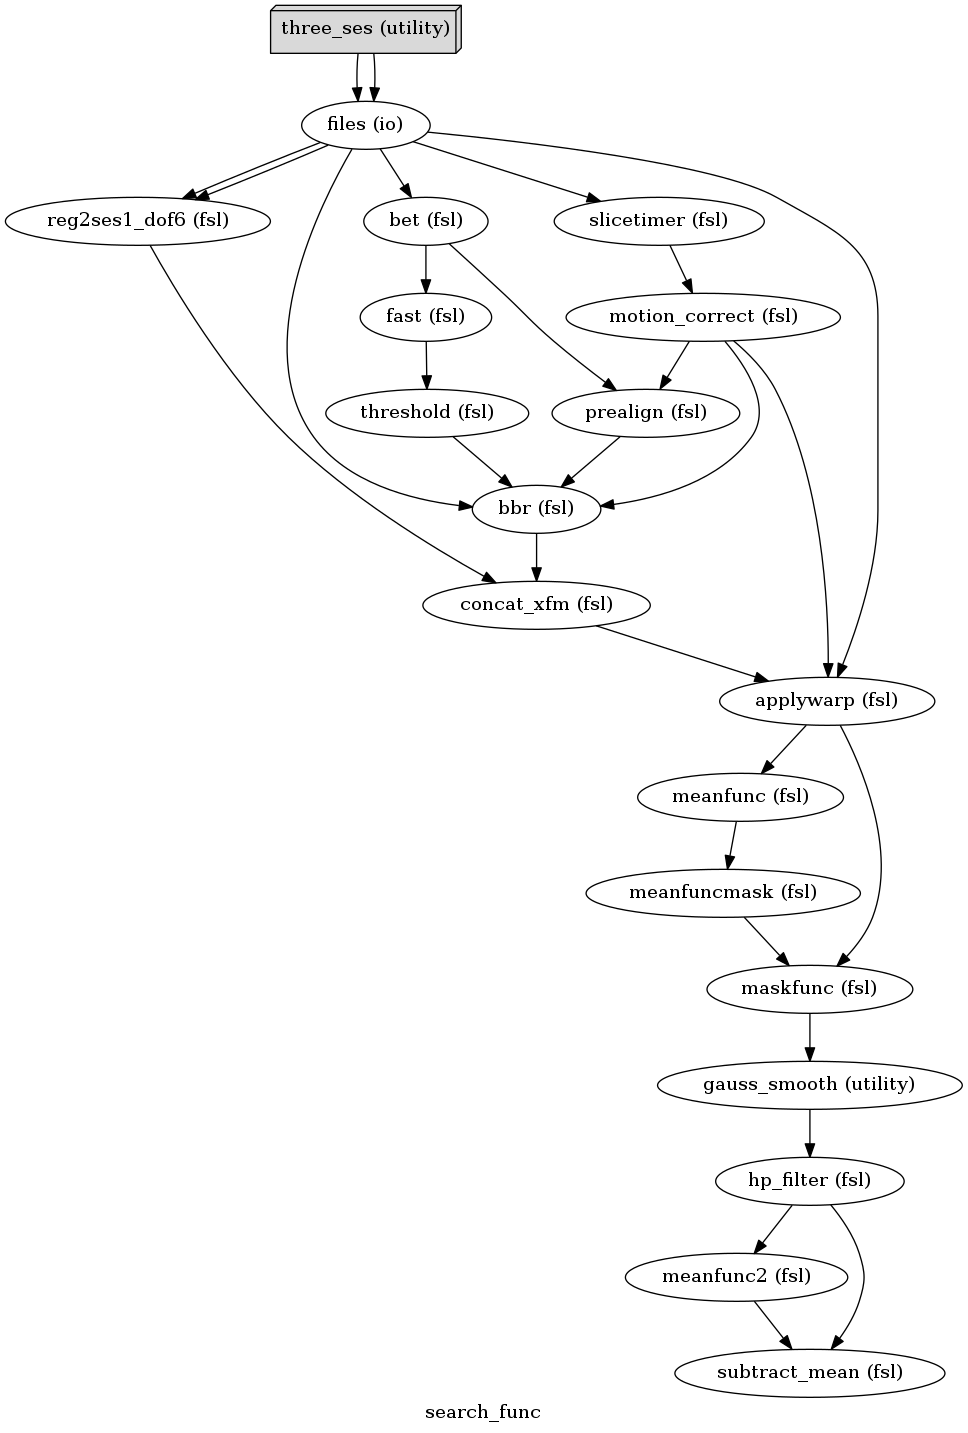

In [22]:
preprocessing.write_graph(simple_form=True, graph2use="hierarchical", dotfilename='./graph_hierarchical.dot')

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

## Registration

In [23]:
subs = pe.Node(
    util.IdentityInterface(
        fields=["sub_id"]),
    name='subs')

# Subjects with four sessions
subs.iterables = [
    ("sub_id", ["sub_%03d" % i for i in range(1, 7)]),
]

# File templates for different subjects and sessions
templates = {
    "inplane1" : 'nii/{sub_id}/ses_000/anatomy/inplane.nii.gz',
    "fs_orig"  : 'fs_subjects/{sub_id}/mri/orig.nii.gz',
    "fs_brain" : 'fs_subjects/{sub_id}/mri/brain.nii.gz',
}

# SelectFiles Node to handle 
# session specific file templates
reg_files = pe.Node(
    SelectFiles(
        templates, 
        base_directory=data_dir, 
        sort_filelist=True),
    name='reg_files')

# BbRegsiter Inplane 1 to hires
bbreg_inplane2hires = pe.Node(
    freesurfer.BBRegister(
        init="fsl",
        contrast_type="t1",
        subjects_dir=fs_dir,
        out_fsl_file=True
    ), 
    name='bbreg_inplane2hires'
)

# Hires to standard Flirt
flirt_hires2standard = pe.Node(
    fsl.FLIRT(
        reference=mni_standard_brain_path,        
    ), 
    name='flirt_hires2standard'
)

# Hires to standard FNirt
fnirt_hires2standard = pe.Node(
    fsl.FNIRT(
        fieldcoeff_file=True,
        field_file=True,
        ref_file=mni_standard_path,
        regularization_model="membrane_energy",
    ), 
    name='fnirt_hires2standard',
)

In [24]:
# Registration to fs hires and to MNI
registration = pe.Workflow(name='registration', base_dir=working_dir)
registration.connect(subs, 'sub_id', bbreg_inplane2hires, 'subject_id')
registration.connect(subs, 'sub_id', reg_files, 'sub_id')
registration.connect(reg_files, 'fs_brain', flirt_hires2standard, 'in_file')
registration.connect(reg_files, 'fs_orig', fnirt_hires2standard, 'in_file')
registration.connect(flirt_hires2standard, 'out_matrix_file', fnirt_hires2standard, 'affine_file')
registration.connect(reg_files, 'inplane1', bbreg_inplane2hires, 'source_file')

180523-16:44:50,529 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


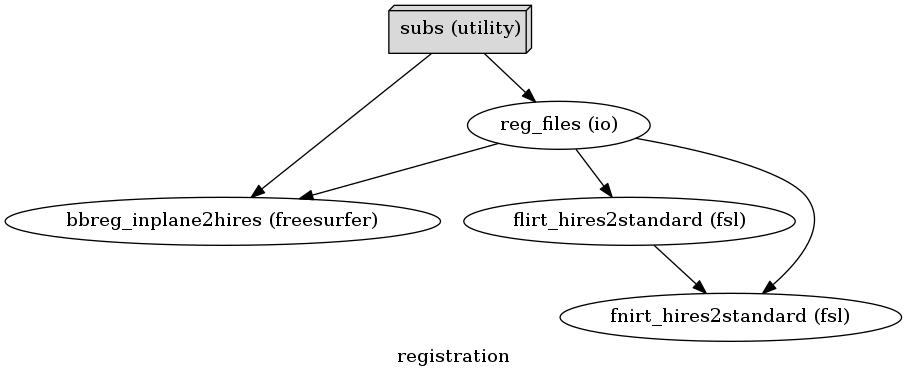

In [25]:
registration.write_graph(simple_form=True, graph2use="hierarchical", dotfilename='./graph_hierarchical.dot')

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

### Output nodes

In [26]:
# Create datasink to store important files in
# useful, more accessable locations.
datasink = pe.Node(
    DataSink(base_directory=base_dir,
             container="output"),
    name='datasink')

# Remove unwanted lengthy strings from filenames.
datasink.inputs.substitutions = [
    ('_sub_id_', ''),
    ('_ses_id_', '')
]

In [27]:
pipe = pe.Workflow(name='pipe', base_dir=working_dir)
pipe.connect(preprocessing, "applywarp.out_file", datasink, 'applywarp')
pipe.connect(preprocessing, "reg2ses1_dof6.out_file", datasink, 'reg2ses1')
pipe.connect(preprocessing, "reg2ses1_dof6.out_matrix_file", datasink, 'reg2ses1.@mat')
pipe.connect(preprocessing, "gauss_smooth.out_file", datasink, 'smooth.@out_file')
pipe.connect(preprocessing, "hp_filter.out_file", datasink, 'highpass.@out_file')
pipe.connect(preprocessing, "subtract_mean.out_file", datasink, 'subtract_mean.@out_file')
pipe.connect(registration, "fnirt_hires2standard.warped_file", datasink, 'register_to_standard.@warped_file')
pipe.connect(registration, "fnirt_hires2standard.field_file", datasink, 'register_to_standard.@field_file')
pipe.connect(registration, "fnirt_hires2standard.fieldcoeff_file", datasink, 'register_to_standard.@fieldcoeff_file')
pipe.connect(registration, "bbreg_inplane2hires.out_reg_file", datasink, 'register_to_standard.@out_reg_file')

180523-16:44:53,862 workflow INFO:
	 Generated workflow graph: ./graph_hierarchical.png (graph2use=hierarchical, simple_form=True).


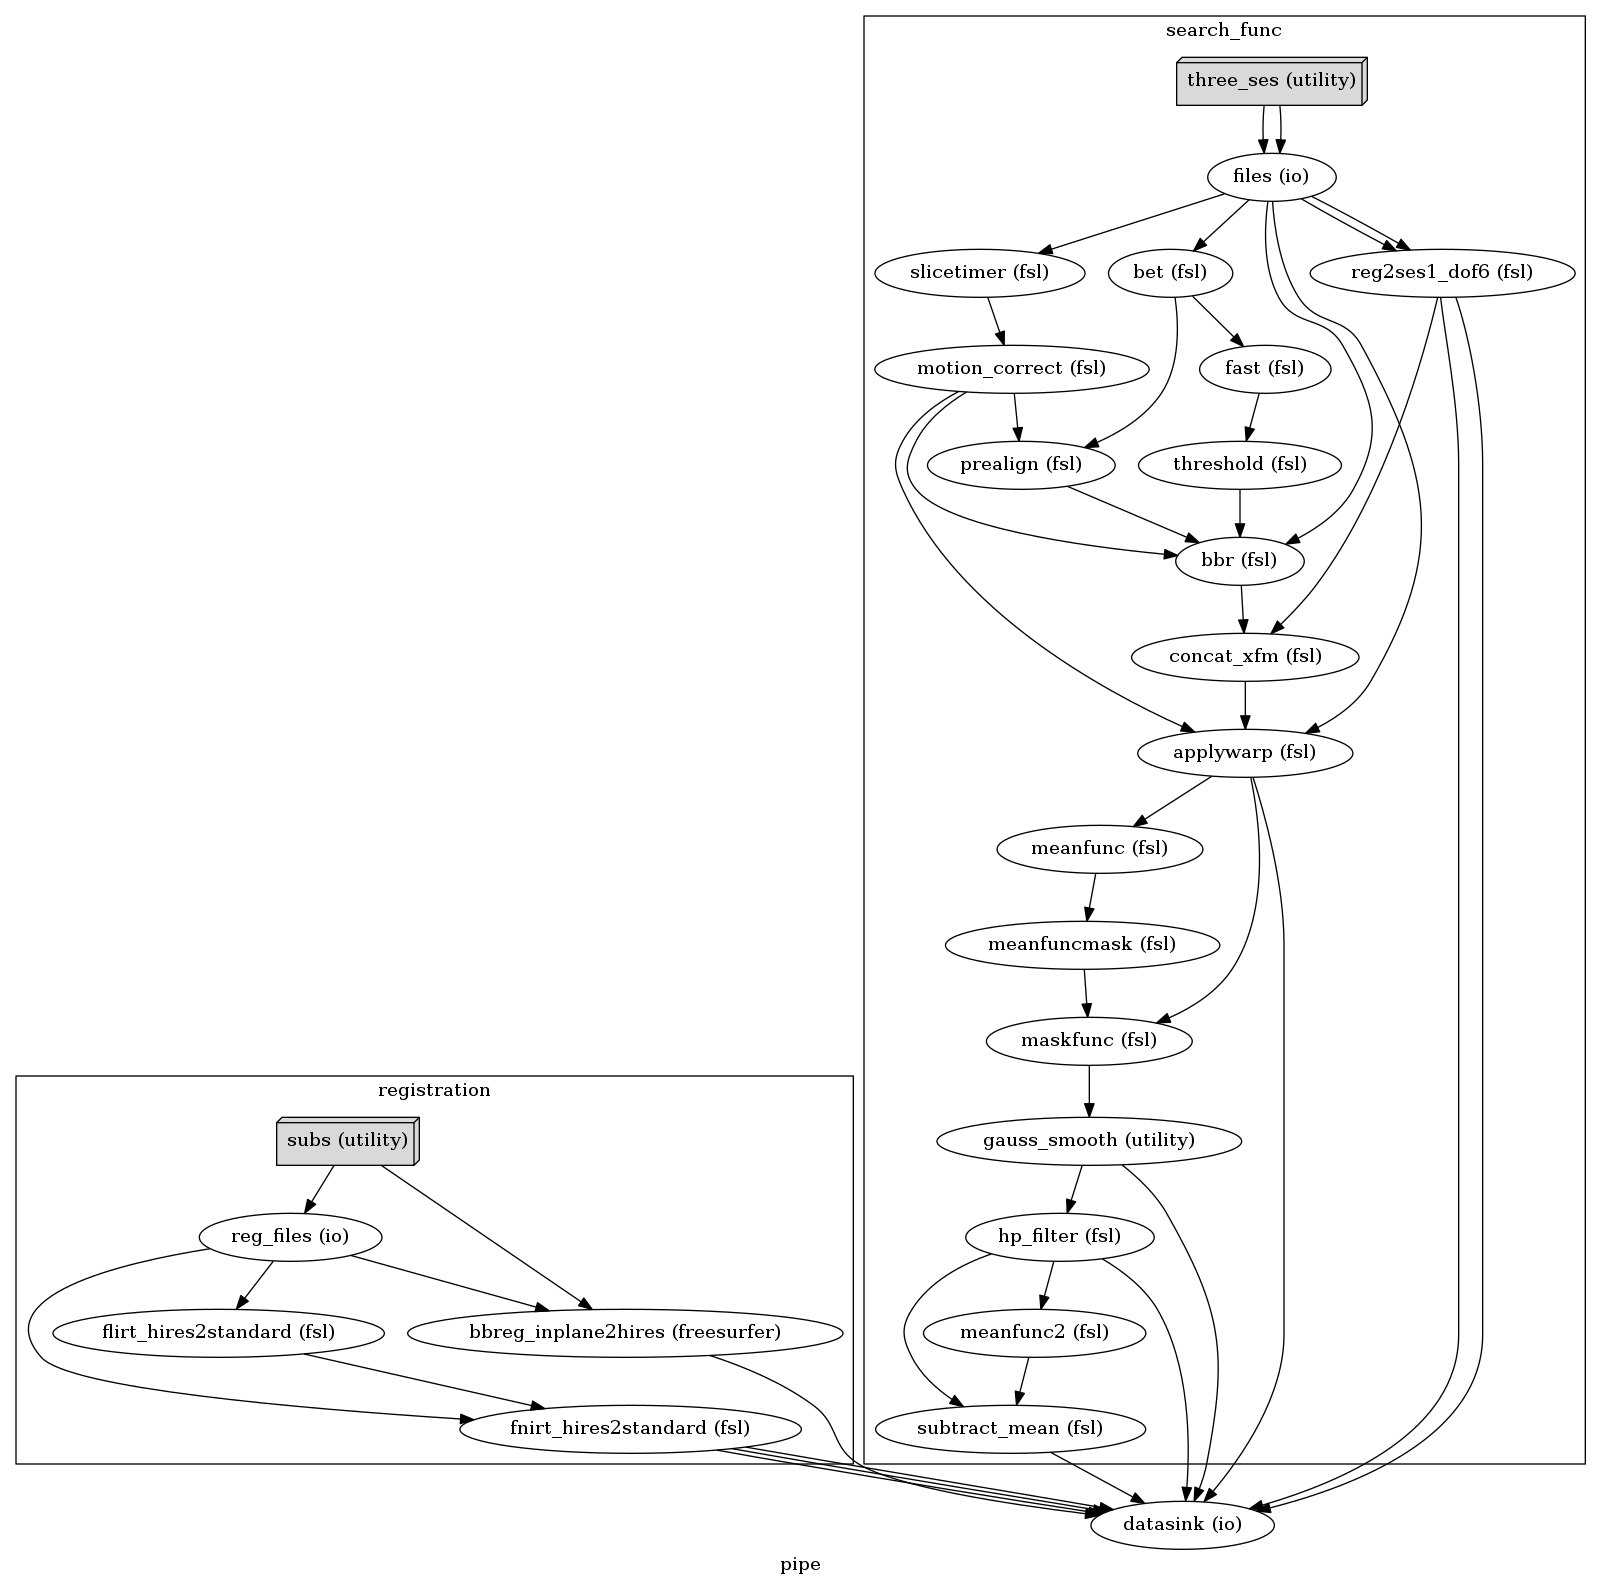

In [28]:
pipe.write_graph(simple_form=True, graph2use="hierarchical", dotfilename='./graph_hierarchical.dot')

# Visualize graph
Image(width=768, filename="graph_hierarchical.png")

In [ ]:
pipe.run(plugin='MultiProc', plugin_args={'n_procs': 4})